# Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

# для подсчёта наилучших параметров для модели использовали from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')


In [2]:
def evaluate_preds(train_true_values, train_pred_values, valud_true_values, valud_pred_values):
    print('R^2 на тренировочной выборке: ' + str(round(r2(train_true_values, train_pred_values), 3)) + '\n' +
          'MAE: ' + str(round(mae(train_true_values, train_pred_values), 3)) + '\n' +
          'MSE: ' + str(round(mse(train_true_values, train_pred_values), 3)))
    print('R^2 на валидационной выборке: ' + str(round(r2(valud_true_values, valud_pred_values), 3)) + '\n' +
          'MAE: ' + str(round(mae(train_true_values, train_pred_values), 3)) + '\n' +
          'MSE: ' + str(round(mse(train_true_values, train_pred_values), 3)))
        
    plt.figure(figsize = (12, 6))
    
    plt.subplot(121)
    sns.scatterplot(x = train_pred_values, y = train_true_values)
    plt.plot([0, 600000], [0, 600000], linestyle = '--', color = 'red')
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истинные значения')
    plt.title('Тренировочная выборка')
    
    plt.subplot(122)
    sns.scatterplot(x = valud_pred_values, y = valud_true_values)
    plt.plot([0, 600000], [0, 600000], linestyle = '--', color = 'red')
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истинные значения')
    plt.title('Валидационная выборка')
    
    plt.show()

###  Загрузка данных

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREDICTIONS_PATH = 'NZhavoronok_predictions.csv'

**Описания полей датасета по недвижимости**
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
df_test = pd.read_csv(TEST_DATASET_PATH, sep=',')
df_test.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [6]:
df_train.shape[1]

20

In [7]:
df_train.shape[1]-1 == df_test.shape[1]

True

### Приведение типов данных

In [8]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_train['Rooms'] = df_train['Rooms'].astype('int64')
df_train['HouseFloor'] = df_train['HouseFloor'].astype('int64')

In [10]:
df_test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [11]:
df_test['Id'] = df_test['Id'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)
df_test['Rooms'] = df_test['Rooms'].astype('int64')
df_test['HouseFloor'] = df_test['HouseFloor'].astype('int64')

### Обзор данных

**Целевая переменная**

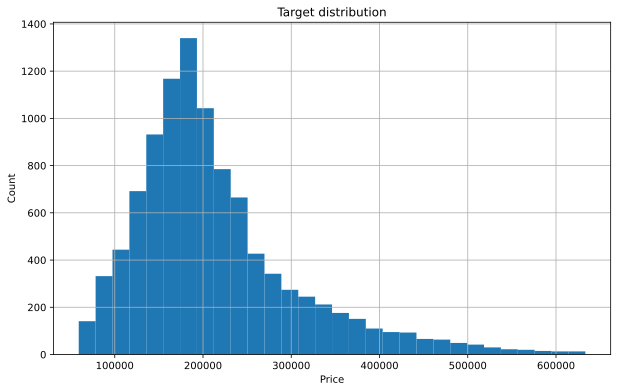

In [12]:
plt.figure(figsize = (10, 6))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

На графике распределения целевой переменной мы видим большой хвост после отметки в 500тыс., 
эти данные нужно детально рассмотреть на предмет включения в анализ, являются ли они аномалией . 
Основная масса квартир приходится на диапазон стоимости примерно 170-190 тыс.

In [13]:
#Посмотрим среднее арифметическое, медиану и моду для цены (таргета) и отразим эти данные на графике распределения цены
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

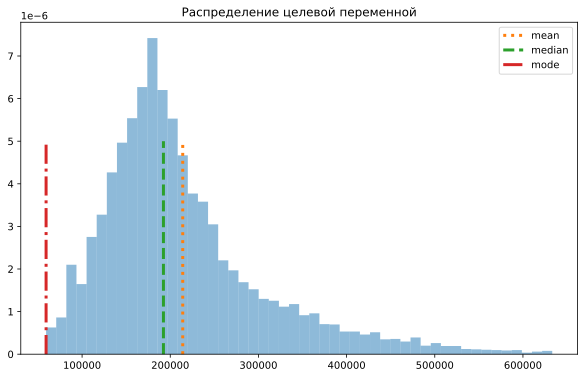

In [14]:
plt.figure(figsize = (10, 6))
plt.hist(df_train['Price'], density=True, bins=50, alpha=0.5)
y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=3)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=3)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=3)
plt.title('Распределение целевой переменной')
plt.legend()
plt.show()

**Количесвенные переменные**

In [15]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
df_test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


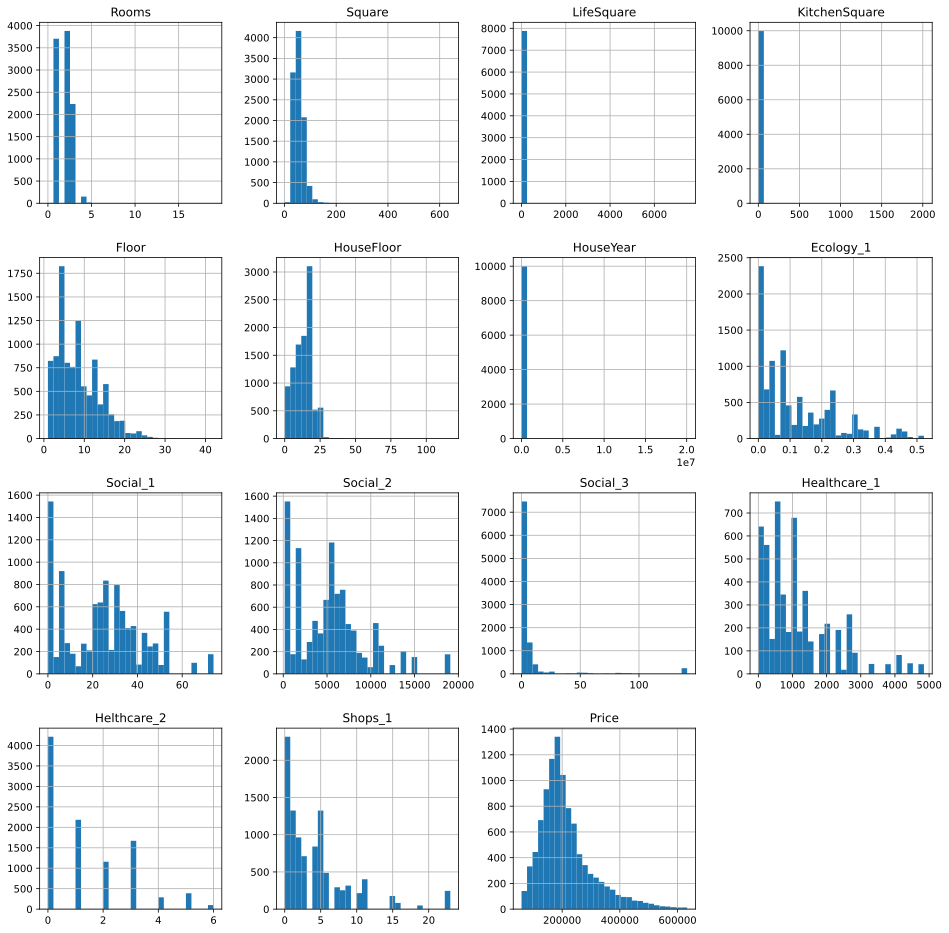

In [17]:
digital_features=df_train.select_dtypes(exclude=['object'])
digital_features.hist(figsize=(16,16), bins=30)
plt.show()

С помощью построение гистограмм для всех признаков тренировочного дф мы видим наличие выбросов в количестве комнат, площади общей, кухни и жилой, этажности дома, годах постройки. Показатели местности Social и Shops интерпретировать трудно, это пoдтверждаеся выводом информации с помощью describe.
Для тестового дф так же актуальны выбросы и аномалии в количестве комнат, площади общей, кухни и жилой, этажности дома. Остальные данные надо проверить на пропуски.

**Номинативные переменные**

In [18]:
df_train.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [19]:
df_train['DistrictId'].value_counts().head()

27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

Чаще всего квартиры находтся в районах под номерами 27, 1, 23 и 6. 

In [20]:
df_train['Ecology_2'].value_counts().head()

B    9903
A      97
Name: Ecology_2, dtype: int64

Более 99% квартир находится в категории В экологического показателя местности.

In [21]:
df_train['Ecology_3'].value_counts().head()

B    9725
A     275
Name: Ecology_3, dtype: int64

Более 97% квартир находится в категории В экологического показателя местности.

In [22]:
df_train['Shops_2'].value_counts().head()

B    9175
A     825
Name: Shops_2, dtype: int64

Более 91% квартир находтся в катеогии В, связанного с наличием магазинов и торговых центров.

**Посмотрим на корреляцию признаков в тренировочном датасете:**

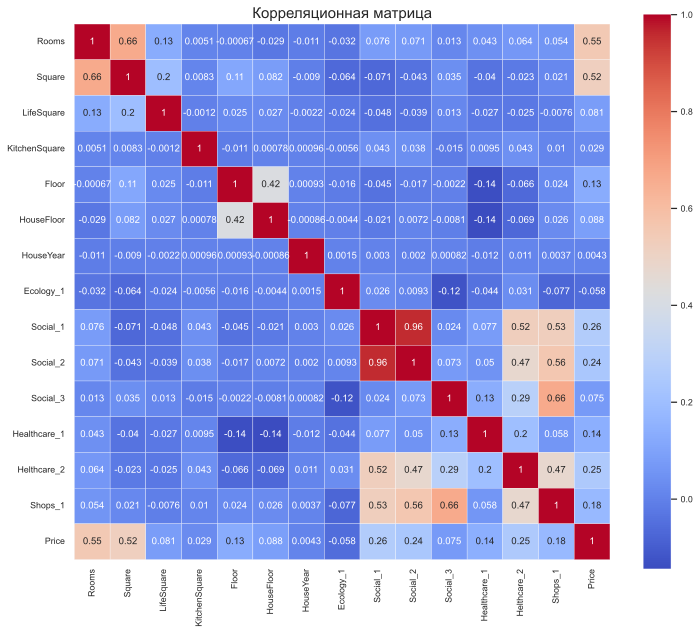

In [23]:
plt.figure(figsize=(12,10))
sns.set(font_scale=0.8)

corr_matrix=df_train.corr()
sns.heatmap(corr_matrix, cbar=True, annot=True, linewidths=0.3, cmap='coolwarm', square=True)
plt.title('Корреляционная матрица', fontsize=15)
plt.show()

Из корреляционной матрицы, на данном этапе анализа, можно сделать вывод,что на таргет (цену квартиры) первостепенно влияет количество комнат и общая площадь квартиры. 

### Обработка пропусков

In [24]:
#Выразим в % содержание пропусков в тренировочном датафрейме.
(len(df_train) - df_train.count())/len(df_train)

Id               0.0000
DistrictId       0.0000
Rooms            0.0000
Square           0.0000
LifeSquare       0.2113
KitchenSquare    0.0000
Floor            0.0000
HouseFloor       0.0000
HouseYear        0.0000
Ecology_1        0.0000
Ecology_2        0.0000
Ecology_3        0.0000
Social_1         0.0000
Social_2         0.0000
Social_3         0.0000
Healthcare_1     0.4798
Helthcare_2      0.0000
Shops_1          0.0000
Shops_2          0.0000
Price            0.0000
dtype: float64

In [25]:
#Выразим в % содержание пропусков в тестовом датафрейме.
(len(df_test) - df_test.count())/len(df_test)

Id               0.0000
DistrictId       0.0000
Rooms            0.0000
Square           0.0000
LifeSquare       0.2082
KitchenSquare    0.0000
Floor            0.0000
HouseFloor       0.0000
HouseYear        0.0000
Ecology_1        0.0000
Ecology_2        0.0000
Ecology_3        0.0000
Social_1         0.0000
Social_2         0.0000
Social_3         0.0000
Healthcare_1     0.4754
Helthcare_2      0.0000
Shops_1          0.0000
Shops_2          0.0000
dtype: float64

В столбцах LifeSquare 21,13% и Healthcare_1 47,98% пропущенных значений в тренировочном датафрейме, 20,82% и 47,54% соответственно в тестовом. По этим столбцам заполним пропуски медианным значением.

**LifeSquare**

In [26]:
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['LifeSquare'].median()

In [27]:
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()

**Healthcare_1**

In [28]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].median()

In [29]:
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

### Обработка выбросов

**Rooms**

In [30]:
df_train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

Мы видим,что чаще всего встречаются квартиры с 2-мя комнатами, затем с 1-ой комнатой и на третьем месте 3 комнаты в квартире. Есть позиция с количеством комнат 0,возможно это студии, но их всего 8 шт на весь датасет, что можно посчитать аномалией. Так же аномальными выглядят данные с количеством комнат 6, 10 и 19. 
Все аномалии заменим медианным значением.

In [31]:
df_train.loc[df_train['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = df_train['Rooms'].median()

In [32]:
df_test['Rooms'].value_counts()

2     2030
1     1769
3     1099
4       90
5        7
6        2
0        2
17       1
Name: Rooms, dtype: int64

Так же как и для df_train,в тестовом дф заменим аномальные значения (0, 6, 17) на медианное значение.

In [33]:
df_test.loc[df_test['Rooms'].isin([0, 6, 17]), 'Rooms'] = df_train['Rooms'].median()

**Square, LifeSquare, KitchenSquare** 

In [34]:
#Для показателей площади квартиры Square найдем выбросы с помощью квантилей. 
#Наблюдения,значения которых больше 97.5% квантиля и меньше 2.5% квантиля будем считать выбросами и заменим на медиану.
df_train.loc[(df_train['Square'] > df_train['Square'].quantile(.975)) | 
             (df_train['Square'] < df_train['Square'].quantile(.025)) |
             (df_train['Square'] == 0), 'Square'] = df_train['Square'].median()

Т.к. общая площадь квартиры включает в себя площадь жилую и площадь кухни, попробуем расчитать долю кухни от общей площади квартиры и долю жилой площади от общей площади квартиры для каждой записи и затем найти медианное значение.

In [35]:
df_train['KSquare/Square'] = df_train['KitchenSquare'] / df_train['Square']

In [36]:
median_ks_s = round(df_train['KSquare/Square'].median(),2)
print("Медианный показатель KSquare/Square: {}".format(median_ks_s))

Медианный показатель KSquare/Square: 0.12


In [37]:
df_train['LSquare/Square'] = df_train['LifeSquare'] / df_train['Square']

In [38]:
median_ls_s = round(df_train['LSquare/Square'].median(),2)
print("Медианный показатель LSquare/Square: {}".format(median_ls_s))

Медианный показатель LSquare/Square: 0.61


Получается,что средний (медианный) показатель площади кухни от общей площади составил 0.12 (12%), а жилой площади от общей площади 0.62 (62%).

Теперь найдем выбросы с помощью квантилей для KitchenSquare, а так же, где показатель доли кухни будет меньше 0.12 и жилой площади больше 0.61, умножим показатель медианной доли на общую площадь квартиры.             

In [39]:
df_train.loc[((df_train['KitchenSquare'] == 0) | (df_train['KSquare/Square'] < 0.12) | 
              (df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975)) | 
             (df_train['KitchenSquare'] < df_train['KitchenSquare'].quantile(.025))), 'KitchenSquare'] = df_train['Square'] * median_ks_s

df_train.loc[((df_train['LSquare/Square'] > 0.61) | (df_train['LifeSquare'] == 0) | (df_train['LifeSquare'] > df_train['Square']) |
             (df_train['LifeSquare'] > df_train['LifeSquare'].quantile(.975)) | 
             (df_train['LifeSquare'] < df_train['LifeSquare'].quantile(.025))), 'LifeSquare'] = df_train['Square'] * median_ls_s

In [40]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,KSquare/Square,LSquare/Square
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,55.108599,31.192276,7.735583,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.123941,0.659285
std,0.811056,15.215053,8.794882,1.973290,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.750255,0.953082
min,1.000000,32.105270,15.146290,3.854860,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.009708
25%,1.000000,42.432730,24.193711,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.022227,0.535078
50%,2.000000,52.513310,31.286030,7.833715,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.119612,0.613226
75%,2.000000,64.591720,34.931942,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,0.165726,0.706577
max,5.000000,100.904263,61.551600,13.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,61.034810,91.567973


Проделаем эти же расчеты для тестового датафрейма.

In [41]:
df_test.loc[(df_test['Square'] > df_test['Square'].quantile(.975)) | 
             (df_test['Square'] < df_test['Square'].quantile(.025)) |
             (df_test['Square'] == 0), 'Square'] = df_test['Square'].median()

In [42]:
df_test['KSquare/Square'] = df_test['KitchenSquare'] / df_test['Square']

In [43]:
median_ks_s_test = round(df_test['KSquare/Square'].median(),2)
print("Медианный показатель KSquare/Square: {}".format(median_ks_s_test))

Медианный показатель KSquare/Square: 0.12


In [44]:
df_test['LSquare/Square'] = df_test['LifeSquare'] / df_test['Square']

In [45]:
median_ls_s_test = round(df_test['LSquare/Square'].median(),2)
print("Медианный показатель LSquare/Square: {}".format(median_ls_s_test))

Медианный показатель LSquare/Square: 0.61


In [46]:
df_test.loc[((df_test['KitchenSquare'] == 0) | (df_test['KSquare/Square'] < 0.12) | 
             (df_test['KitchenSquare'] > df_test['KitchenSquare'].quantile(.975)) 
             | (df_test['KitchenSquare'] < df_test['KitchenSquare'].quantile(.025))),
            'KitchenSquare'] = df_test['Square'] * median_ks_s_test

df_test.loc[((df_test['LSquare/Square'] > 0.61) | (df_test['LifeSquare'] == 0) | (df_test['LifeSquare'] > df_test['Square']) |
            (df_test['LifeSquare'] > df_test['LifeSquare'].quantile(.975)) | 
             (df_test['LifeSquare'] < df_test['LifeSquare'].quantile(.025))), 'LifeSquare'] = df_test['Square'] * median_ls_s_test

In [47]:
df_test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,KSquare/Square,LSquare/Square
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,1.906200,55.450402,31.456550,7.716235,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.115118,0.646021
std,0.805935,15.286441,8.808994,1.928101,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.223009,0.240067
min,1.000000,32.113449,14.525566,3.869204,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.006302
25%,1.000000,42.703356,24.437747,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,0.022519,0.537875
50%,2.000000,52.921340,31.681083,7.814682,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.119521,0.613901
75%,2.000000,65.215668,35.473437,9.068753,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,0.164496,0.701828
max,5.000000,100.729995,61.445297,12.087599,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,14.487571,6.221508


**Floor, HouseFloor**

In [48]:
df_train['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int64)

В графе HouseFloor этажность дома 0 - это аномалия.

In [49]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [50]:
#Заменим 0 значения в этажности дома на медианное значение.
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

In [51]:
#Проверим аномалии в соответствии этажа, на котором находится квартира, и этажности дома. 
#Заменим эти значения на случайные из возможной этажности соответствующего дома.
floor_outliers = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [52]:
# проделаем эти же преобразования для тестового датафрейма
df_test['HouseFloor'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 39, 40, 48, 99], dtype=int64)

In [53]:
df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] = df_test['HouseFloor'].median()

In [54]:
floor_outliers_test = df_test.loc[df_test['Floor'] > df_test['HouseFloor']].index
df_test.loc[floor_outliers_test, 'Floor'] = df_test.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [55]:
df_train['HouseYear'].sort_values(ascending=False).unique()

array([20052011,     4968,     2020,     2019,     2018,     2017,
           2016,     2015,     2014,     2013,     2012,     2011,
           2010,     2009,     2008,     2007,     2006,     2005,
           2004,     2003,     2002,     2001,     2000,     1999,
           1998,     1997,     1996,     1995,     1994,     1993,
           1992,     1991,     1990,     1989,     1988,     1987,
           1986,     1985,     1984,     1983,     1982,     1981,
           1980,     1979,     1978,     1977,     1976,     1975,
           1974,     1973,     1972,     1971,     1970,     1969,
           1968,     1967,     1966,     1965,     1964,     1963,
           1962,     1961,     1960,     1959,     1958,     1957,
           1956,     1955,     1954,     1953,     1952,     1951,
           1950,     1948,     1947,     1942,     1941,     1940,
           1939,     1938,     1937,     1936,     1935,     1934,
           1933,     1932,     1931,     1930,     1929,     1

Мы видим значение 20052011 и 4968, что являются странными для записи года постройки. Заменим из на медианное значение.

In [56]:
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = df_train['HouseYear'].median()

### Отбор и построение новых признаков

**Dummies**

Переведем в числовое представление категориальные признаки Ecology_2, Ecology_3 и Shops_2

In [57]:
df_train['Ecology_2_bin'] = df_train['Ecology_2'].replace({'A':0, 'B':1})
df_train['Ecology_3_bin'] = df_train['Ecology_3'].replace({'A':0, 'B':1})
df_train['Shops_2_bin'] = df_train['Shops_2'].replace({'A':0, 'B':1})

In [58]:
df_test['Ecology_2_bin'] = df_test['Ecology_2'].replace({'A':0, 'B':1})
df_test['Ecology_3_bin'] = df_test['Ecology_3'].replace({'A':0, 'B':1})
df_test['Shops_2_bin'] = df_test['Shops_2'].replace({'A':0, 'B':1})

**Отбор признаков для моделей**

In [59]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'KSquare/Square',
 'LSquare/Square',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin']

In [60]:
feature_names = [ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
                 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_bin',
                 'Ecology_3_bin', 'Shops_2_bin']
target_name = 'Price'

In [61]:
#соединим все признаки
df = df_train[feature_names + [target_name]]
df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,2,47.981561,29.268752,6.000000,7,9,1969,0.089040,33,7976,5,900.0,0,11,1,1,1,184966.930730
1,3,65.683640,40.049543,8.000000,7,9,1978,0.000070,46,10309,1,240.0,1,16,1,1,1,300009.450063
2,2,44.947953,27.418251,5.393754,8,12,1968,0.049637,34,7759,0,229.0,1,3,1,1,1,220925.908524
3,2,53.352981,32.545319,9.000000,8,17,1977,0.437885,23,5735,3,1084.0,0,5,1,1,1,175616.227217
4,1,39.649192,23.776169,7.000000,11,12,1976,0.012339,35,5776,1,2078.0,2,4,1,1,1,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,50.401785,30.476203,6.048214,1,5,1968,0.135650,46,7960,6,350.0,3,11,1,1,1,196684.316040
9996,1,41.521546,20.539216,9.000000,13,13,2000,0.000000,30,5562,0,900.0,0,5,1,1,0,189050.289571
9997,1,47.939008,29.242795,5.752681,12,16,2015,0.072158,2,629,1,900.0,0,0,1,1,0,159143.805370
9998,2,43.602562,26.597563,8.000000,1,5,1961,0.307467,30,5048,9,325.0,2,5,1,0,1,181595.339808


**Разобъем обработанные данные на тренировочную и валидацинную выборки:**

In [62]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.3, shuffle=True, random_state=42)

Рассмотрим 2 модели RandomForestRegressor и GradientBoostingRegressor (LinearRegression показала наименьший результат в поске модели)

**RandomForestRegressor**

R^2 на тренировочной выборке: 0.782
MAE: 27699.799
MSE: 1972897482.323
R^2 на валидационной выборке: 0.65
MAE: 27699.799
MSE: 1972897482.323


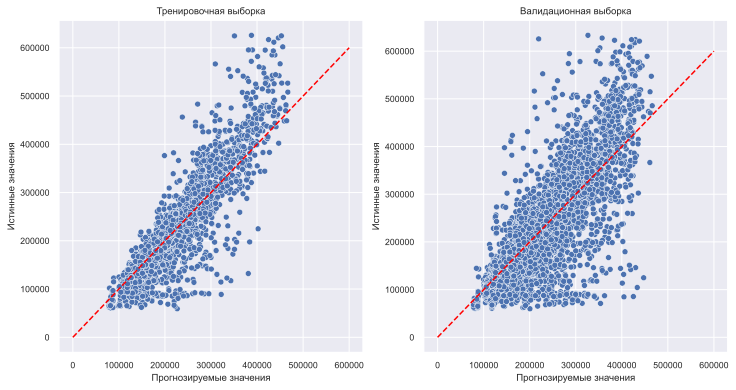

In [63]:
# При помощи GridSearchCV были найдены лучшие параменты для модели: {'max_depth': 10, 'n_estimators': 400}
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10, 
                                 max_features=10,
                                 min_samples_leaf=8,
                                 random_state=42,
                                 n_estimators=400
                                )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [64]:
# Проверка модели
cv_score = cross_val_score(rf_model, X, y, scoring = 'r2', cv = KFold(n_splits = 5, shuffle = True, random_state = 42))
print('R^2 при кросс-валидации: ', cv_score.mean().round(3))

R^2 при кросс-валидации:  0.693


Отобразим важность признаков в модели RandomForestRegressor

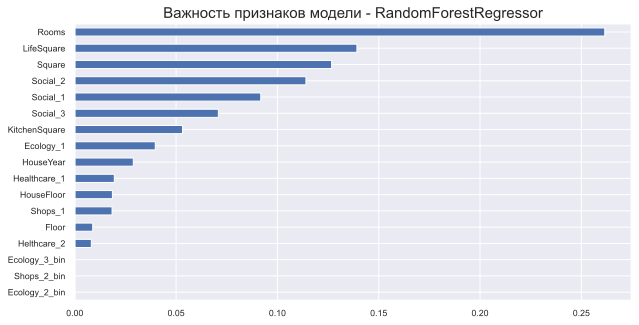

In [65]:
rf_model.fit(X, y)
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index = feature_names)
feat_importances.sort_values(ascending = True, inplace = True)
feat_importances.plot(kind = 'barh', figsize = (10, 5))
plt.title('Важность признаков модели - RandomForestRegressor', fontsize = 15)
plt.show()

**GradientBoostingRegressor**

R^2 на тренировочной выборке: 0.911
MAE: 18672.794
MSE: 804222400.474
R^2 на валидационной выборке: 0.673
MAE: 18672.794
MSE: 804222400.474


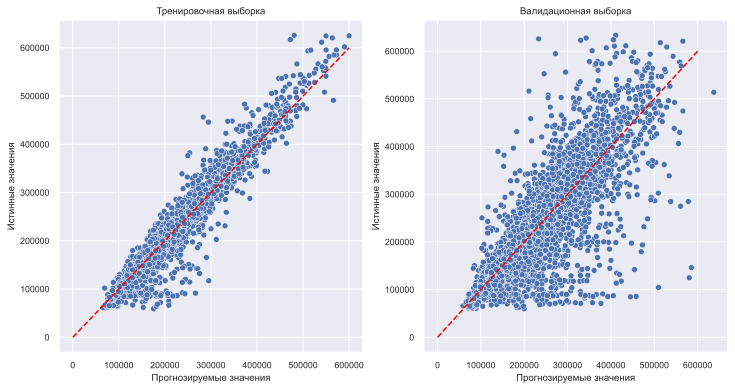

In [66]:
# При помощи GridSearchCV были найдены лучшие параменты для модели:{'max_depth': 5, 'n_estimators': 200}
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=200
                                    )

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [67]:
cv_score = cross_val_score(gb_model, X, y, scoring = 'r2', cv = KFold(n_splits = 5, shuffle = True, random_state = 42))
print('R^2 при кросс-валидации: ', cv_score.mean().round(3))

R^2 при кросс-валидации:  0.727


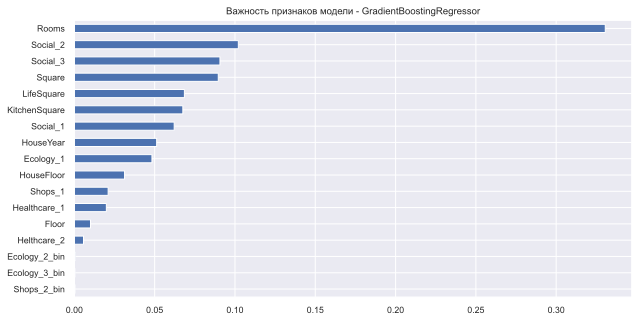

In [68]:
gb_model.fit(X, y)
importances = gb_model.feature_importances_
feat_importances = pd.Series(importances, index = feature_names)
feat_importances.sort_values(ascending = True, inplace = True)
feat_importances.plot(kind = 'barh', figsize = (10, 5))
plt.title('Важность признаков модели - GradientBoostingRegressor')
plt.show()

Обе модели показали примерно одинаковый результат прогнозирования цен на валидационной выборке тренировочного датафрейма. Но при использовании модели GradientBoostingRegressor подсчитанные ошибки показали меньшую величину в сравнении с RandomForestRegressor, по этому ее выбираем лучшей моделью для предсказания цен на df_test.

### Предсказание цен на df_test

In [69]:
X_test = df_test[feature_names]
y_test_pred = gb_model.predict(X_test)
df_test['Price'] = y_test_pred

In [70]:
df_test.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8', sep=',')